# Задача 2

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов.
Эксперимент проходил с 2022-04-24 по 2022-04-30 включительно. Для эксперимента были задействованы 2 и 1 группы. 
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест,
                                                     Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и
                                                     тест Манна-Уитни поверх бакетного преобразования).

Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.
Ваше решение — это ссылка на merge request с проведенным анализом.


In [1]:
import pandas as pd
from read_db.CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')
import hashlib
from scipy import stats
import numpy as np
from tqdm.auto import tqdm
#import swifter

In [2]:
df = Getch(
    '''
    select exp_group
            ,user_id
            ,sum(action='like') as likes
            ,sum(action='view') as views
            ,likes/views as ctr
    from simulator_20220520.feed_actions 
    where toDate(time) between '2022-04-24' and '2022-04-30'
        and exp_group in (1,2)
    group by exp_group, user_id
    '''
).df

In [3]:
df.describe()

,exp_group,user_id,likes,views,ctr
count,20031.000000,20031.000000,20031.000000,20031.000000,20031.000000
mean,1.496830,75343.140432,13.448954,66.224652,0.215016
std,0.500002,53262.345755,10.865224,45.095939,0.117862
min,1.000000,206.000000,0.000000,1.000000,0.000000
25%,1.000000,22034.000000,6.000000,32.000000,0.117021
50%,1.000000,109234.000000,11.000000,56.000000,0.195122
75%,2.000000,126220.500000,18.000000,90.000000,0.291667
max,2.000000,141164.000000,95.000000,321.000000,0.923077


In [4]:
data = df.groupby('exp_group',as_index =False).agg({'user_id':'count','likes':'sum','views':'sum'}) 
data['ctr']=data['likes']/data['views']
data
# группы примерно одинакового размера. ctr в контрольной группе выше чем ctr в тестовой. Надо проверить насколько это статистически значимо, чтобы делать выводы.

,exp_group,user_id,likes,views,ctr
0,1,10079,139011,668236,0.208027
1,2,9952,130385,658310,0.198060


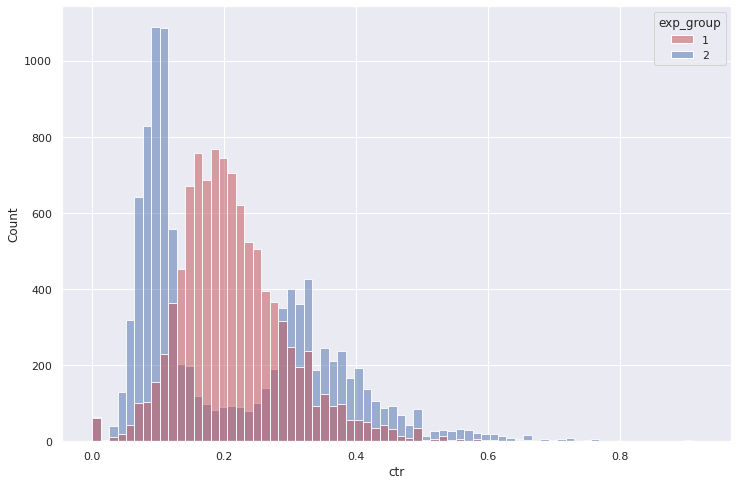

In [5]:
sns.set(rc={'figure.figsize':(12,8)})
groups = sns.histplot(data =df
                     ,x='ctr'
                     ,hue='exp_group'
                     ,palette = ['r','b']
                     ,alpha=0.5
                     ,kde=False)
#По гистограмме видим, что группы не похожи.
#1 группа имеет одномодальное распределние с небольшой положительной ассиметрией. Почти похоже на нормальное распределение(но это неточно).
#2 группа имеет двухмодальное распределение. Моды которого отличаются по высоте, но все равно сильно выражены. Сильно скошено влево.

### t-тест

In [6]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)
# ттест показал, что наши группы ожинаковые. Наверно, потому что вторая группу сильно скошено влево и  имеет двумодальное распределение (далеко от нормального).

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

### тест Манна-Уитни

In [7]:
print(stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr))

#A_gt_B = 0
#for _ in range(10000):
#    A_gt_B += df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
#print('B', A_gt_B/100,'% случаев А > B. Должно получиться около 50%.')

# Тест Манна-Уитни показал, что наши группы различаются (p-value меньше а=0,05). Он не привязан к распределению нашей метрики. ????

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)


### Пуассоновский бутстреп

In [8]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstrap1 = stats.poisson(1).rvs(
        (2000, len(likes1))).astype(np.int64)
    
    poisson_bootstrap2 = stats.poisson(1).rvs(
        (2000, len(likes2))).astype(np.int64)  
        
    globalCTR1=(poisson_bootstrap1*likes1).sum(axis=1)/(poisson_bootstrap1*views1).sum(axis=1)
    
    globalCTR2=(poisson_bootstrap2*likes2).sum(axis=1)/(poisson_bootstrap2*views2).sum(axis=1) 
    
    return globalCTR1, globalCTR2

In [9]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [10]:
ctr1, ctr2 = bootstrap(likes1,views1,likes2,views2)

<AxesSubplot:ylabel='Count'>

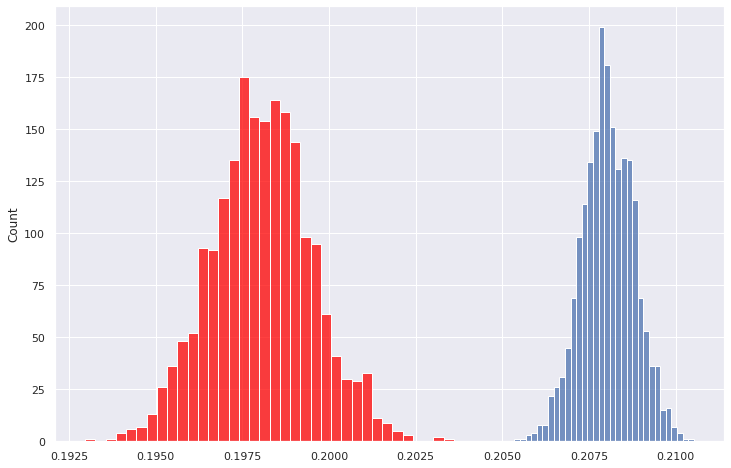

In [11]:
sns.histplot(ctr1)
sns.histplot(ctr2, color = 'red')

<AxesSubplot:ylabel='Count'>

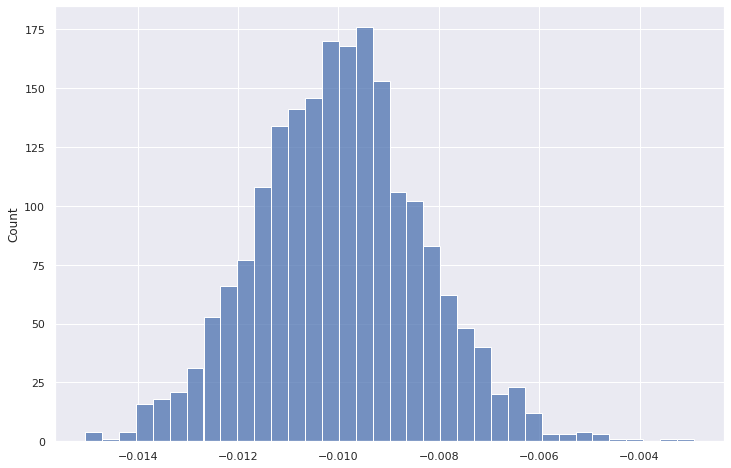

In [12]:
sns.histplot(ctr2-ctr1)
# Пуассоновский будстреп тоже показывает, что есть различия.Две гистограммы совсем не пересекаютсяю
#Мы видим, что разница ctr отрицательная. Т.е. в целом новый алгоритм рекомендаций работает хуже, чем текущей.

### t-тест на сглаженном ctr (α=5)

In [13]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr)/(user_views + alpha)
    return smothed_ctr

In [14]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
global_ctr_1,global_ctr_2

(0.20802680490126244, 0.1980601844115994)

In [15]:
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()
#sns.distplot(group1.ctr, kde = False)
#sns.distplot(group2.ctr, kde = False)

In [16]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'],x['views'],global_ctr_2,5), axis=1)
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'],x['views'],global_ctr_1,5), axis=1)

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='smothed_ctr'>

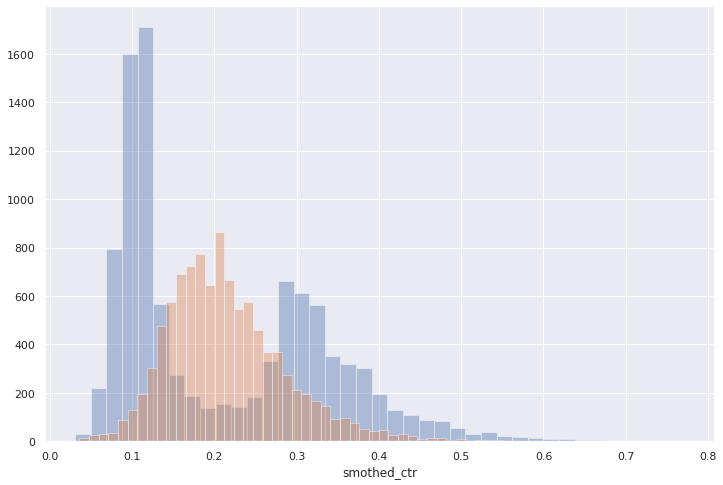

In [17]:
sns.distplot(group2.smothed_ctr, kde = False)
sns.distplot(group1.smothed_ctr, kde = False)

In [18]:
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

# Показал статистические различия

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

### t-тест и тест Манна-Уитни поверх бакетного преобразования

In [19]:
df = Getch(
    '''
    select exp_group,bucket
            ,sum(likes)/sum(views) as bucket_ctr
            ,quantileExact(0.9)(ctr) as ctr9
    from (select exp_group
                ,xxHash64(user_id)%50 as bucket
                ,user_id
                ,sum(action='like') as likes
                ,sum(action='view') as views
                ,likes/views as ctr
        from simulator_20220520.feed_actions 
        where toDate(time) between '2022-04-24' and '2022-04-30'
            and exp_group in (1,2)
        group by exp_group, user_id)
    group by exp_group,bucket
    '''
    ).df

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

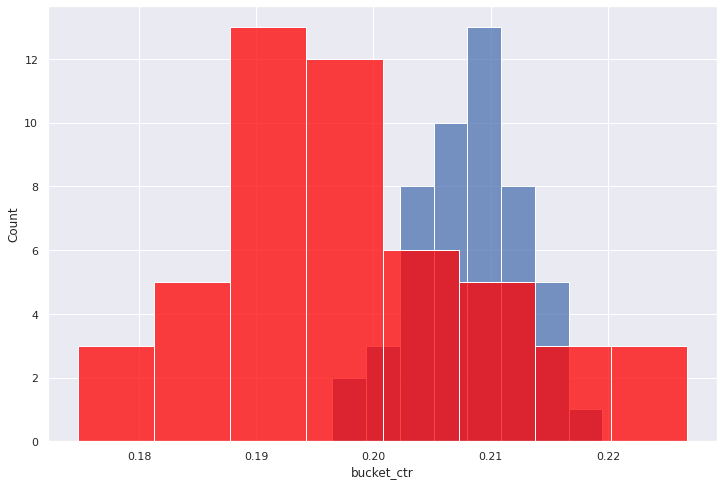

In [20]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)
sns.histplot(df[df.exp_group == 2].bucket_ctr,color ='red')

In [21]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr,
                df[df.exp_group == 2].bucket_ctr,
                equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [22]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                    df[df.exp_group == 2].bucket_ctr,
                    alternative = 'two-sided')
#При бакетном преобразовании оба распределения имеют одномодальный вид + нет выбросов и скошенности. 
#Поэтому ттест должен работать +/- корректно и он показывает, что группы не одинаковые. Аналогочтно тест Манна-Утни.

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.
Ваше решение — это ссылка на merge request с проведенным анализом.

### Давайте дополнительно проведем аналитику динамики pvalue

In [23]:
df_date = Getch(
    '''
    select exp_group
            ,user_id
            ,toDate(time) as date
            ,sum(action='like') as likes
            ,sum(action='view') as views
            ,likes/views as ctr
    from simulator_20220520.feed_actions 
    where toDate(time) between '2022-04-24' and '2022-04-30'
        and exp_group in (1,2)
    group by exp_group, user_id,toDate(time) 
    '''
).df

In [24]:
df_date.head(2)

,exp_group,user_id,date,likes,views,ctr
0,2,135020,2022-04-25,1,15,0.066667
1,1,131596,2022-04-27,10,46,0.217391


In [25]:
df_date_group = df_date.groupby(['exp_group','date'], as_index=False).agg({'likes':'sum','views':'sum'})
df_date_group['ctr'] = df_date_group['likes']/df_date_group['views']
df_date_group.head(2)

,exp_group,date,likes,views,ctr
0,1,2022-04-24,18195,85606,0.212544
1,1,2022-04-25,15927,78079,0.203986


In [26]:
days = df_date_group.groupby('date',as_index =False).min().date
days

0   2022-04-24
1   2022-04-25
2   2022-04-26
3   2022-04-27
4   2022-04-28
5   2022-04-29
6   2022-04-30
Name: date, dtype: datetime64[ns]

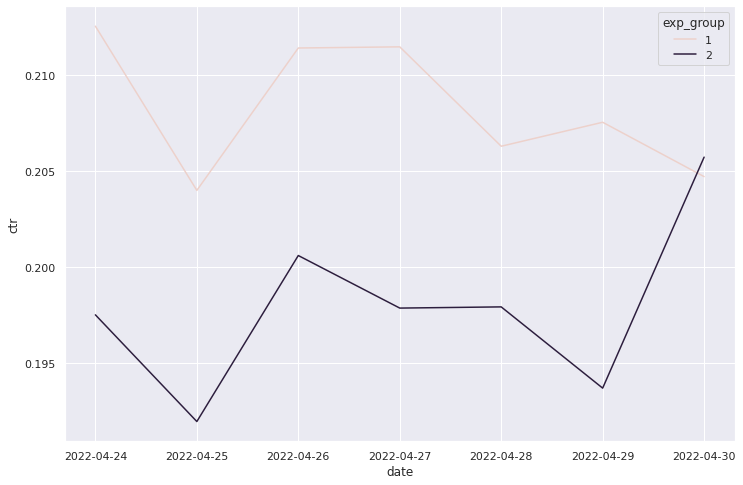

In [27]:
ax = sns.lineplot(data=df_date_group, x ='date',y='ctr',hue='exp_group',color='r')

<AxesSubplot:xlabel='ctr', ylabel='Count'>

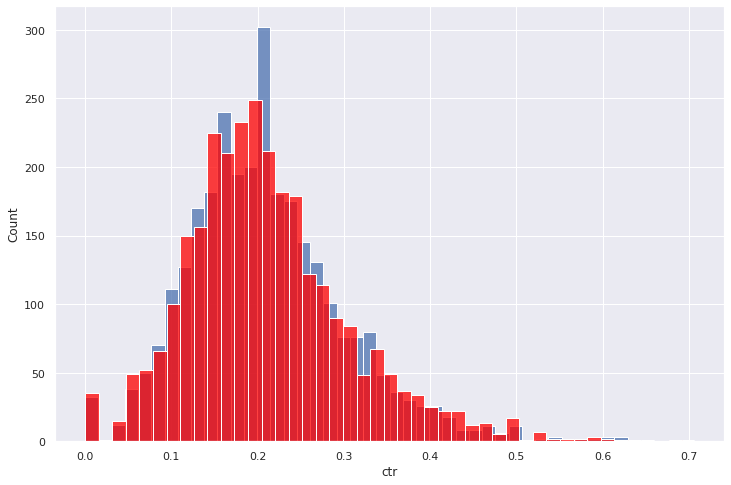

In [28]:
day = '2022-04-30'
df_day = df_date[df_date['date'] == day]
stats.mannwhitneyu(df_day[df_day.exp_group == 1].ctr,
               df_day[df_day.exp_group == 2].ctr)

sns.histplot(df_day[df_day.exp_group == 1].ctr)
sns.histplot(df_day[df_day.exp_group == 2].ctr,color ='red')


In [29]:
pvalue = []
for day in days:
    df_day = df_date[df_date['date'] == day]
    pvalue.append(stats.ttest_ind(df_day[df_day.exp_group == 1].ctr,
               df_day[df_day.exp_group == 2].ctr)[1])

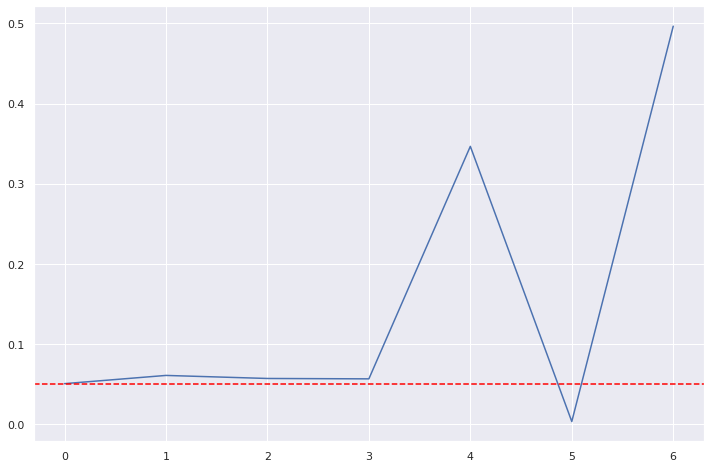

In [30]:
ax = sns.lineplot(data=pvalue,color='b')
ax.axhline(0.05, ls ='--',color = 'red')

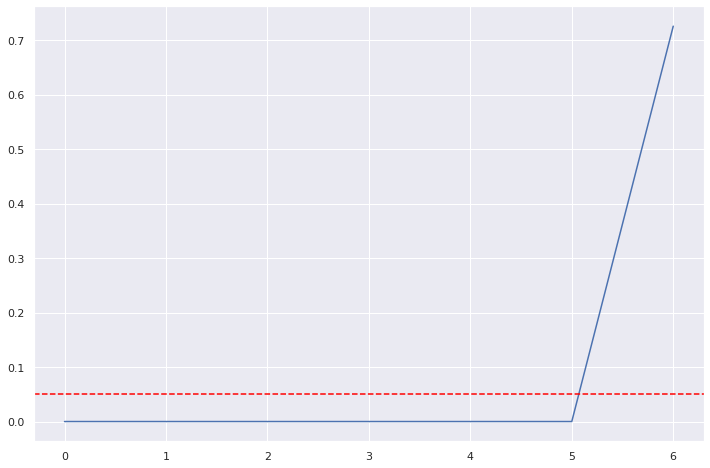

In [31]:
pvalue = []
for day in days:
    df_day = df_date[df_date['date'] == day]
    pvalue.append(stats.mannwhitneyu(df_day[df_day.exp_group == 1].ctr,
               df_day[df_day.exp_group == 2].ctr)[1])

ax = sns.lineplot(data=pvalue,color='b')
ax.axhline(0.05, ls ='--',color = 'red')

# Выводы

Группы примерно одинакового размера. Но ctr в контрольной группе(1) выше чем ctr в тестовой(2). Надо проверить, насколько это статистически значимо, чтобы делать выводы. На первый взгляд расскатывать новый алгоритм не стоит. 

На глаз по графику мы видим, что группы даволно сильно отличаются.

1 группа имеет одномодальное распределние с небольшой положительной ассиметрией. Почти похоже на нормальное распределение(но это неточно).

2 группа имеет двухмодальное распределение. Моды которого отличаются по высоте, но все равно сильно выражены. Сильно скошено влево.

После проведения ряда тестов можно сделать следующие выводы:

- В этих двух группах ctr статистически различный. Это показали все тесты кроме ttest. Он показал неправильный результат, так как не работает корректно на двумодальном распределении, со скосами и сильными выбросами (это помог невелировать сглаженный ctr).
- Пуассоновский будстреп показывает, что разница ctr отрицательная. Т.е. в целом новый алгоритм рекомендаций работает хуже, чем текущей.

- Предполагаю, что распределение во 2 группе двумодальное, потому что большей части пользователей не понравилось нововедение, они стали меньше лайкать (мода - 0.1), но другой части(менее большой) наоборот очень понравилось наше нововдение и они стали больше лайкать (мода -0.3). Почему так? надо провести дополнительный анализ, можно ли разделить эти группы по какому-то критерию (пол, возраст, источник и т.д.)

- Хм....Насколько правильно выбран период? Мы видим, что у двух групп ctr отличается сразу с самого первого дня. При этом три дня отличается одинаково(один тренд). Дальше поведение немного меняется, а в последний день, они вообще сходятся. Распределение по 2 группе 30 апреля становится из двумодального одномодальным И p-value по тесту Манна-Уитни показывает, что в последний день разница перестала быть статзначимой. Возможно в нашей компании принято, проводить тесты с периодом - 7 дней (выявлено бэкграундом), но я бы посмотрела, как ведет себя наш тест еще несколько дней. 

- Вопрос: почему именно такая динамики и двумодальное распределение первые 6 дней. Сомневаюсь, что пользователи прочуствовали новую фишку с самого первого дня, поэтому несовсем логично ведет себя тренд. На мой взгляд разница должна была возникать постепенно (но может я не права).

Рекомендация: предлагаю пока не раскатывать новый алгоритм на всех новых пользователей. Так как:
- во-первух, тесты показывают что разница статзначима, а следовательно новый алгоритм работает хуже чем текущий и требует доработки
- во-вторых, новый аналитик, в моем лице, советует продолжить тестирование еще хотя бы на несколько дней
- в-третьих, необходим доп анализ пользователей из второй группы. Возможно,новый алгоритм по большей степени заточен на определенную группу и она в восторге от него (ctr = 0.3), в то время как остальным новый алгоритм условие уходшил (ctr = 0.1)

P.S. вычленить эту группу сходу не получилось

In [39]:
df_all_2 = Getch(
    '''
    select exp_group
            ,user_id
            ,os
            ,age
            ,multiIf(age = 0, 'no info',
                 age <=20 , '1-20',
                 age <=23 , '21-23',
                 age <=26 , '24-26',
                 age <=30 , '26-30',
                 '30+') as age_type            
            ,source
            ,country
            ,city
            ,gender
           ,toDate(time) as date
           ,Hour(time) as hour
            ,sum(action='like') as likes
            ,sum(action='view') as views
            ,round(likes/views,1) as ctr
    from simulator_20220520.feed_actions 
    where toDate(time) between '2022-04-24' and '2022-04-30'
        and exp_group in (2)
    group by exp_group, user_id,toDate(time),Hour(time)
            ,os
            ,age
            ,source
            ,country
            ,city
            ,gender
    '''
).df

In [40]:
df_all_2.head(2)

,exp_group,user_id,os,age,age_type,source,country,city,gender,date,hour,likes,views,ctr
0,2,25324,Android,34,30+,ads,Russia,Chelyabinsk,0,2022-04-27,14,3,8,0.4
1,2,19704,Android,36,30+,ads,Russia,Dobryanka,1,2022-04-24,21,7,18,0.4


In [43]:
#df_all_2.groupby(['age','ctr'], as_index = False).agg({'user_id':'count'})\
 #       .pivot()

pivot = pd.pivot_table(df_all_2, values ='user_id', index=['date','hour','gender','os','source'],
                    columns=['ctr'], aggfunc='count').sort_values(0.3, ascending = False)

pivot['dif']= pivot[0.1]-pivot[0.3]
pivot[pivot['dif'] < 0]

ctr                                      0.0   0.1   0.2   0.3  0.4  0.5  0.6  \
date       hour gender os      source                                           
2022-04-30 13   1      Android organic  11.0  19.0  24.0  21.0  6.0  2.0  NaN   
2022-04-29 21   1      Android organic  16.0  13.0   6.0  18.0  8.0  3.0  1.0   
2022-04-30 21   1      Android organic   3.0  14.0  27.0  16.0  8.0  1.0  NaN   
           19   0      Android ads       2.0  14.0  18.0  16.0  4.0  NaN  NaN   
           18   0      Android ads      12.0  10.0  20.0  15.0  4.0  1.0  1.0   
           0    1      Android organic   7.0  12.0  15.0  15.0  7.0  NaN  NaN   
           14   0      Android organic   3.0   7.0  15.0  14.0  4.0  1.0  NaN   
           13   0      Android ads       8.0  10.0  13.0  14.0  2.0  2.0  1.0   
           0    0      Android organic   2.0   7.0  17.0  14.0  4.0  1.0  NaN   
           12   0      Android organic   3.0  12.0  21.0  13.0  2.0  2.0  NaN   
2022-04-24 21   1      Android ads       5.0  10.0   2.0  11.0  3.0  3.0  NaN   
2022-04-30 7    0      Android organic   4.0   3.0  19.0  10.0  5.0  2.0  1.0   
           17   0      Android ads       5.0   8.0  18.0  10.0  6.0  NaN  1.0   
           10   1      iOS     ads       5.0   5.0  10.0   9.0  2.0  NaN  1.0   
2022-04-26 15   0      Android ads      19.0   8.0   9.0   9.0  1.0  3.0  NaN   
2022-04-30 21   0      iOS     organic   5.0   8.0   7.0   9.0  1.0  NaN  NaN   
           20   0      Android ads       3.0   7.0  16.0   9.0  5.0  3.0  1.0   
           3    1      Android organic   3.0   6.0   7.0   8.0  2.0  1.0  NaN   
2022-04-24 7    0      Android organic   7.0   6.0   9.0   8.0  9.0  6.0  NaN   
2022-04-30 14   0      iOS     organic   2.0   7.0   5.0   8.0  4.0  NaN  NaN   
           13   0      iOS     ads       2.0   6.0   8.0   8.0  4.0  1.0  NaN   
2022-04-26 13   1      Android organic  12.0   7.0  12.0   8.0  4.0  NaN  2.0   
2022-04-30 6    1      Android ads       2.0   2.0  10.0   7.0  3.0  NaN  NaN   
                0      Android organic   2.0   6.0  10.0   7.0  NaN  3.0  1.0   
           17   1      iOS     ads       3.0   6.0   8.0   7.0  4.0  NaN  1.0   
           0    0      iOS     organic   NaN   2.0   7.0   7.0  2.0  NaN  NaN   
           20   1      iOS     ads       3.0   5.0   4.0   7.0  2.0  1.0  1.0   
2022-04-26 13   1      iOS     ads      12.0   6.0   4.0   7.0  1.0  1.0  1.0   
2022-04-28 12   0      iOS     ads       4.0   5.0   7.0   6.0  NaN  1.0  1.0   
2022-04-26 11   1      iOS     organic  10.0   4.0   2.0   6.0  NaN  1.0  NaN   
2022-04-30 0    0      Android ads       NaN   5.0   9.0   6.0  3.0  NaN  NaN   
2022-04-28 22   1      iOS     organic   6.0   4.0   7.0   6.0  2.0  1.0  1.0   
2022-04-30 6    0      Android ads       2.0   3.0   5.0   6.0  2.0  1.0  NaN   
2022-04-27 10   0      iOS     organic   6.0   4.0   7.0   5.0  3.0  3.0  4.0   
2022-04-30 4    1      Android ads       1.0   2.0   4.0   5.0  NaN  2.0  1.0   
           2    1      Android ads       1.0   3.0   6.0   5.0  NaN  NaN  NaN   
           1    0      Android ads       1.0   3.0  12.0   5.0  1.0  1.0  NaN   
           4    0      Android organic   2.0   3.0   8.0   5.0  2.0  NaN  NaN   
           18   0      iOS     ads       3.0   3.0   8.0   5.0  NaN  1.0  NaN   
           15   0      iOS     ads       2.0   1.0  13.0   5.0  3.0  NaN  NaN   
           6    1      iOS     ads       1.0   3.0   3.0   5.0  NaN  NaN  NaN   
2022-04-28 4    1      Android organic   4.0   3.0   5.0   5.0  2.0  1.0  1.0   
2022-04-25 2    0      Android ads       2.0   4.0   2.0   5.0  2.0  1.0  NaN   
2022-04-24 3    1      Android organic   2.0   4.0   6.0   5.0  7.0  NaN  NaN   
           23   1      iOS     ads       4.0   3.0   2.0   4.0  1.0  1.0  NaN   
2022-04-25 7    1      iOS     organic   2.0   2.0   2.0   4.0  NaN  2.0  NaN   
           12   0      iOS     ads       5.0   2.0   2.0   4.0  1.0  NaN  1.0   
2022-04-26 6    0      Android 

<AxesSubplot:xlabel='ctr', ylabel='Count'>

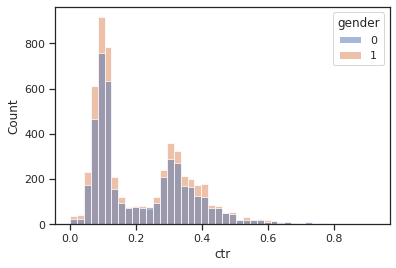

In [7]:
sns.histplot(data =df_all_2
                     ,x='ctr'
                     ,hue='gender'
                     #,palette = ['r','b']
                     ,alpha=0.5
                     ,kde=False)